# DeltaBench Analysis: Reasoning Critics for Finding Logical Mistakes

This notebook provides a comprehensive analysis of the DeltaBench dataset and evaluation of reasoning critics.

In [1]:
# Setup
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

sys.path.append('src')

from src import DeltaBenchDataset, LLMCritic, DeltaBenchEvaluator, plot_results
from src.analysis_utils import display_example, display_critic_comparison, summarize_results

# Set up plotting
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Load and Explore Dataset

In [2]:
# Load dataset
dataset = DeltaBenchDataset()
data = dataset.load_jsonl('data/Deltabench_v1.jsonl')
print(f"Loaded {len(data)} examples")

# Get basic statistics
stats = dataset.get_statistics()
print(f"\nDataset Statistics:")
print(f"  Total examples: {stats['total_examples']}")
print(f"  Examples with errors: {stats['examples_with_errors']}")
print(f"  Error rate: {stats['error_rate']:.2%}")

Loaded 1236 examples

Dataset Statistics:
  Total examples: 1236
  Examples with errors: 1236
  Error rate: 100.00%


In [4]:
# Task type distribution
print("\nTask L1 Distribution:")
for task, count in sorted(stats['task_l1_distribution'].items(), key=lambda x: x[1], reverse=True):
    print(f"  {task}: {count} ({count/stats['total_examples']*100:.1f}%)")


Task L1 Distribution:
  math: 562 (45.5%)
  code: 373 (30.2%)
  Physics&Chemistry&Biology: 154 (12.5%)
  general: 147 (11.9%)


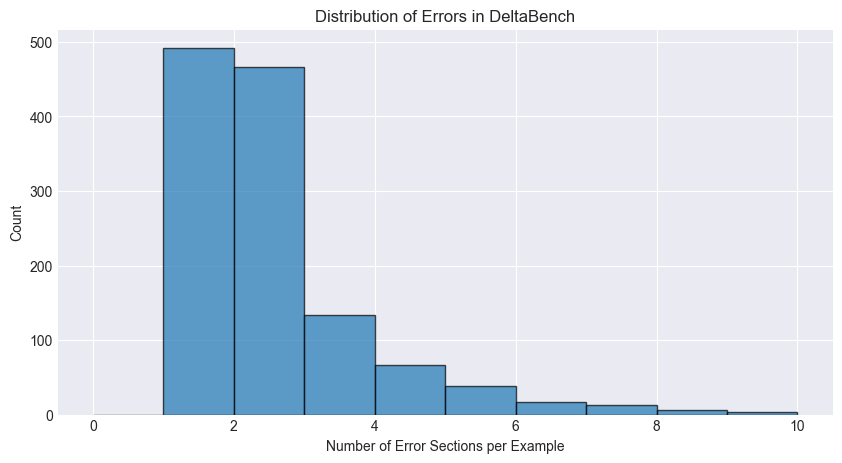


Error distribution:
  1 errors: 492 examples (39.8%)
  2 errors: 466 examples (37.7%)
  3 errors: 134 examples (10.8%)
  4 errors: 67 examples (5.4%)
  5 errors: 38 examples (3.1%)
  6 errors: 17 examples (1.4%)
  7 errors: 13 examples (1.1%)
  8 errors: 6 examples (0.5%)
  9 errors: 3 examples (0.2%)


In [5]:
# Visualize error distribution
error_counts = []
for ex in dataset.data:
    n_errors = len(ex.get('reason_error_section_numbers', [])) + len(ex.get('reason_unuseful_section_numbers', []))
    error_counts.append(n_errors)

plt.figure(figsize=(10, 5))
plt.hist(error_counts, bins=range(max(error_counts) + 2), alpha=0.7, edgecolor='black')
plt.xlabel('Number of Error Sections per Example')
plt.ylabel('Count')
plt.title('Distribution of Errors in DeltaBench')
plt.show()

print(f"\nError distribution:")
error_dist = Counter(error_counts)
for n_errors, count in sorted(error_dist.items()):
    print(f"  {n_errors} errors: {count} examples ({count/len(dataset.data)*100:.1f}%)")

## 2. Examine Example Problems

In [6]:
# Get examples with errors
error_examples = dataset.get_examples_with_errors(limit=5)
print(f"Found {len(error_examples)} examples with errors (showing first 5)\n")

# Display first example in detail
display_example(error_examples[0], dataset, show_sections=True)

Found 5 examples with errors (showing first 5)

Example ID: f11c7a6bbf5754fee116b638d99a33a6
Task Type: math / Number Theory
Origin: Omni-MATH_pascal

QUESTION:
----------------------------------------
We call the pair $(m, n)$ of positive integers a happy pair if the greatest
common divisor of $m$ and $n$ is a perfect square. For example, $(20, 24)$ is a
happy pair because the greatest common divisor of 20 and 24 is 4. Suppose that
$k$ is a positive integer such that $(205800, 35k)$ is a happy pair. What is the
number of possible values of $k$ with $k \leq 2940$?

FINAL ANSWER:
----------------------------------------
30
Correct: 0

ERRORS:
----------------------------------------
Error sections: [7]
Unuseful sections: []

REASONING SECTIONS:
----------------------------------------

Section 1:
  Let's tackle this problem step by step. we need to find the number of positive
  integers \( k \) with \( k \leq 2940 \) such that the pair \( (205800, 35k) \)
  is a "happy pair." a happy pa

In [7]:
# Look at different error patterns
print("Examples with different numbers of errors:\n")

# Example with 1 error
for ex in dataset.data:
    if len(ex.get('reason_error_section_numbers', [])) == 1:
        print("Example with 1 error:")
        display_example(ex, dataset, show_sections=False)
        break

# Example with multiple errors
for ex in dataset.data:
    if len(ex.get('reason_error_section_numbers', [])) > 2:
        print("\nExample with multiple errors:")
        display_example(ex, dataset, show_sections=False)
        break

Examples with different numbers of errors:

Example with 1 error:
Example ID: f11c7a6bbf5754fee116b638d99a33a6
Task Type: math / Number Theory
Origin: Omni-MATH_pascal

QUESTION:
----------------------------------------
We call the pair $(m, n)$ of positive integers a happy pair if the greatest
common divisor of $m$ and $n$ is a perfect square. For example, $(20, 24)$ is a
happy pair because the greatest common divisor of 20 and 24 is 4. Suppose that
$k$ is a positive integer such that $(205800, 35k)$ is a happy pair. What is the
number of possible values of $k$ with $k \leq 2940$?

FINAL ANSWER:
----------------------------------------
30
Correct: 0

ERRORS:
----------------------------------------
Error sections: [7]
Unuseful sections: []


Example with multiple errors:
Example ID: c0a010287ff003fa260c2d57d0a5ec8a
Task Type: math / Discrete Mathematics
Origin: MATH-test

QUESTION:
----------------------------------------
Bob and Alice each have a bag that contains one ball of each of

## 3. Error Categorization Analysis

Let's categorize errors by type and difficulty to understand patterns better.

In [8]:
# Error Categorization by Task Type and Error Position
def categorize_errors(dataset):
    error_categories = {
        'early_errors': [],  # Errors in first 3 sections
        'late_errors': [],   # Errors in last 3 sections  
        'middle_errors': [], # Errors in middle sections
        'single_errors': [], # Examples with exactly 1 error
        'multiple_errors': [], # Examples with 2+ errors
        'by_task_type': {}
    }
    
    for ex in dataset.data:
        error_sections = ex.get('reason_error_section_numbers', [])
        if not error_sections:
            continue
            
        # Get total sections for this example
        total_sections = len(ex.get('reason_steps', []))
        
        # Categorize by position
        for err_sec in error_sections:
            if err_sec <= 3:
                error_categories['early_errors'].append(ex)
            elif err_sec > total_sections - 3:
                error_categories['late_errors'].append(ex)
            else:
                error_categories['middle_errors'].append(ex)
        
        # Categorize by count
        if len(error_sections) == 1:
            error_categories['single_errors'].append(ex)
        else:
            error_categories['multiple_errors'].append(ex)
            
        # Categorize by task type
        task_type = ex.get('task_l1', 'Unknown')
        if task_type not in error_categories['by_task_type']:
            error_categories['by_task_type'][task_type] = []
        error_categories['by_task_type'][task_type].append(ex)
    
    return error_categories

error_cats = categorize_errors(dataset)

print("Error Categorization Results:")
print(f"Early errors (sections 1-3): {len(error_cats['early_errors'])}")
print(f"Middle errors: {len(error_cats['middle_errors'])}")
print(f"Late errors: {len(error_cats['late_errors'])}")
print(f"Single error examples: {len(error_cats['single_errors'])}")
print(f"Multiple error examples: {len(error_cats['multiple_errors'])}")

print("\nErrors by task type:")
for task, examples in error_cats['by_task_type'].items():
    print(f"  {task}: {len(examples)} examples with errors")

Error Categorization Results:
Early errors (sections 1-3): 474
Middle errors: 0
Late errors: 1152
Single error examples: 900
Multiple error examples: 273

Errors by task type:
  math: 509 examples with errors
  general: 146 examples with errors
  Physics&Chemistry&Biology: 150 examples with errors
  code: 368 examples with errors


Error Type Analysis:
Reasoning Depth: 0 examples
Calculation Errors: 0 examples
Logical Fallacies: 0 examples
Assumption Errors: 0 examples


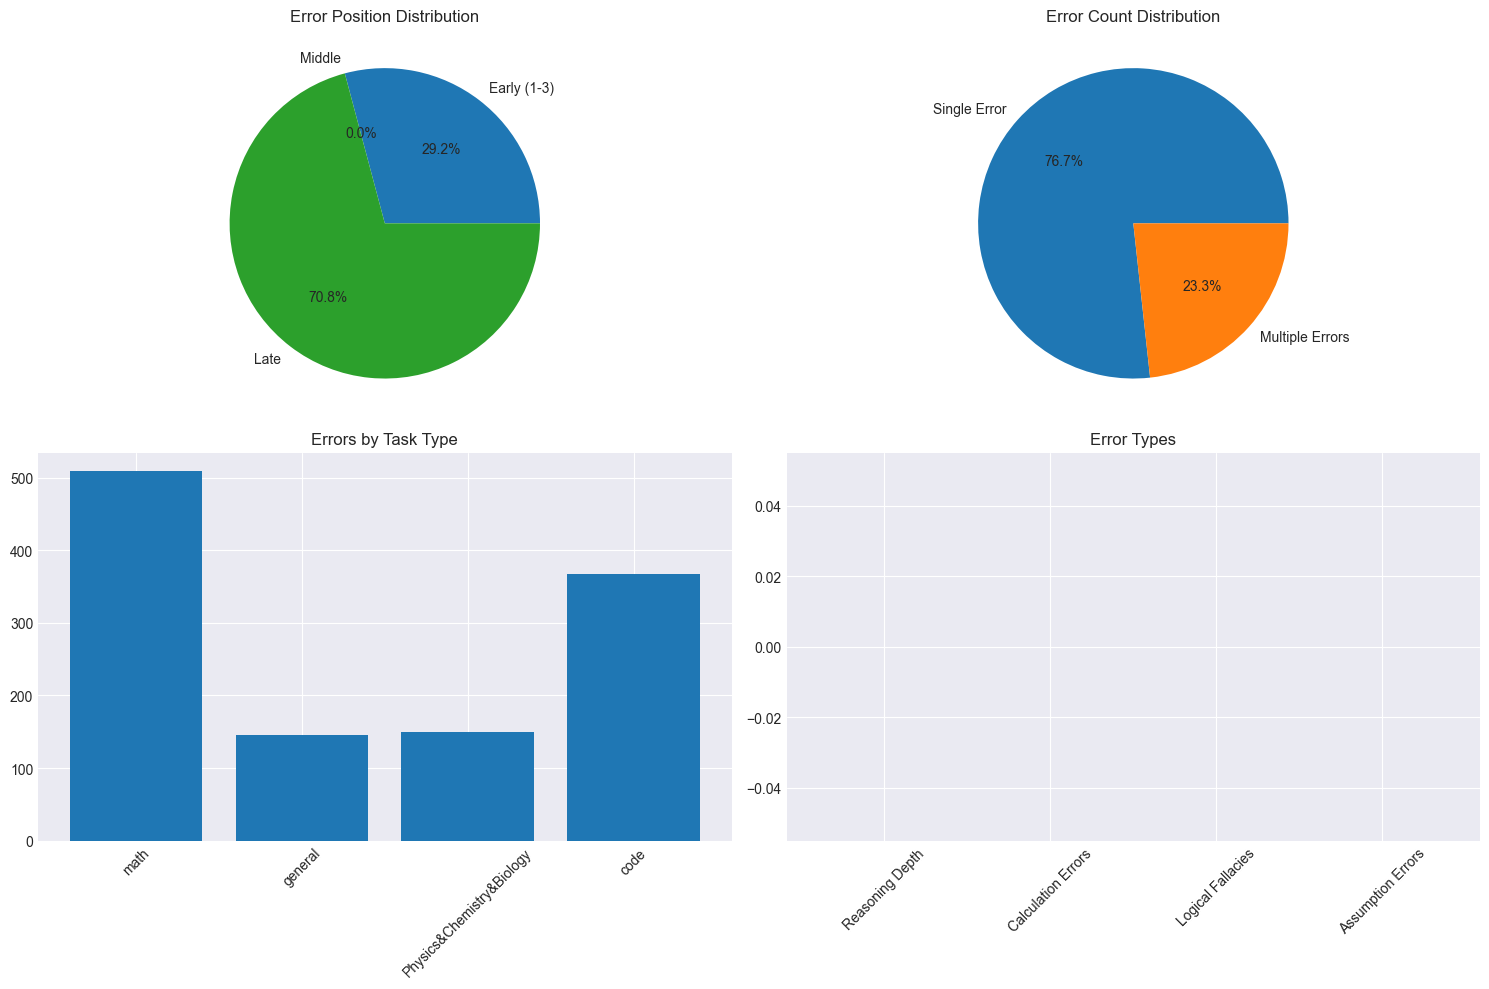

In [9]:
# Detailed Error Type Analysis
def analyze_error_types(dataset):
    error_analysis = {
        'reasoning_depth': [],
        'calculation_errors': [],
        'logical_fallacies': [],
        'assumption_errors': []
    }
    
    for ex in dataset.data:
        error_sections = ex.get('reason_error_section_numbers', [])
        if not error_sections:
            continue
            
        reasoning_steps = ex.get('reason_steps', [])
        error_step_texts = [reasoning_steps[i-1] for i in error_sections if i <= len(reasoning_steps)]
        
        # Simple heuristic classification based on content
        for step_text in error_step_texts:
            text_lower = step_text.lower()
            
            # Look for calculation patterns
            if any(calc_word in text_lower for calc_word in ['calculate', 'compute', '=', 'multiply', 'divide', 'add', 'subtract']):
                error_analysis['calculation_errors'].append(ex)
            
            # Look for logical reasoning patterns  
            elif any(logic_word in text_lower for logic_word in ['therefore', 'because', 'since', 'if', 'then', 'thus']):
                error_analysis['logical_fallacies'].append(ex)
            
            # Look for assumption patterns
            elif any(assume_word in text_lower for assume_word in ['assume', 'given', 'suppose', 'let']):
                error_analysis['assumption_errors'].append(ex)
            
            else:
                error_analysis['reasoning_depth'].append(ex)
    
    return error_analysis

error_types = analyze_error_types(dataset)

print("Error Type Analysis:")
for error_type, examples in error_types.items():
    print(f"{error_type.replace('_', ' ').title()}: {len(examples)} examples")

# Visualize error categorizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Error position distribution
pos_data = [len(error_cats['early_errors']), len(error_cats['middle_errors']), len(error_cats['late_errors'])]
axes[0,0].pie(pos_data, labels=['Early (1-3)', 'Middle', 'Late'], autopct='%1.1f%%')
axes[0,0].set_title('Error Position Distribution')

# Error count distribution  
count_data = [len(error_cats['single_errors']), len(error_cats['multiple_errors'])]
axes[0,1].pie(count_data, labels=['Single Error', 'Multiple Errors'], autopct='%1.1f%%')
axes[0,1].set_title('Error Count Distribution')

# Task type distribution
task_names = list(error_cats['by_task_type'].keys())
task_counts = [len(examples) for examples in error_cats['by_task_type'].values()]
axes[1,0].bar(task_names, task_counts)
axes[1,0].set_title('Errors by Task Type')
axes[1,0].tick_params(axis='x', rotation=45)

# Error type distribution
type_names = list(error_types.keys())
type_counts = [len(examples) for examples in error_types.values()]
axes[1,1].bar([name.replace('_', ' ').title() for name in type_names], type_counts)
axes[1,1].set_title('Error Types')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Test Critic on Sample Examples

In [10]:
# Initialize critics
deltabench_critic = LLMCritic(model_name="gpt-4o-mini", prompt_type="deltabench")
pedcot_critic = LLMCritic(model_name="gpt-4o-mini", prompt_type="pedcot")

# Create evaluators
deltabench_evaluator = DeltaBenchEvaluator(dataset, deltabench_critic)
pedcot_evaluator = DeltaBenchEvaluator(dataset, pedcot_critic)

print("Critics initialized successfully")

Critics initialized successfully


In [11]:
# Test on a single example
test_example = error_examples[0]

print("Testing both critics on example:")
print(f"Question: {test_example['question'][:100]}...")
print(f"True errors: {test_example.get('reason_error_section_numbers', [])}")

# Evaluate with both critics
deltabench_result = deltabench_evaluator.evaluate_example(test_example)
pedcot_result = pedcot_evaluator.evaluate_example(test_example)

# Display comparison
results_dict = {
    'deltabench': deltabench_result,
    'pedcot': pedcot_result
}

display_critic_comparison(test_example, results_dict, dataset)

Testing both critics on example:
Question: We call the pair $(m, n)$ of positive integers a happy pair if the greatest common divisor of $m$ an...
True errors: [7]
Error calling gpt-4o-mini: Error code: 401 - {'error': {'message': "You didn't provide an API key. You need to provide your API key in an Authorization header using Bearer auth (i.e. Authorization: Bearer YOUR_KEY), or as the password field (with blank username) if you're accessing the API from your browser and are prompted for a username and password. You can obtain an API key from https://platform.openai.com/account/api-keys.", 'type': 'invalid_request_error', 'param': None, 'code': None}}
Error calling gpt-4o-mini: Error code: 401 - {'error': {'message': "You didn't provide an API key. You need to provide your API key in an Authorization header using Bearer auth (i.e. Authorization: Bearer YOUR_KEY), or as the password field (with blank username) if you're accessing the API from your browser and are prompted for a usernam

## 5. Stratified Sampling Evaluation (50 Examples)

Let's run a more systematic evaluation using stratified sampling to ensure we test across different error types and task categories.

In [ ]:
# Stratified sampling for comprehensive evaluation
import random
random.seed(42)

def stratified_sample(dataset, error_cats, n_samples=50):
    """Create a stratified sample ensuring representation across categories"""
    
    # Define strata based on error categories
    strata = {
        'single_early': [],
        'single_middle': [], 
        'single_late': [],
        'multiple_errors': [],
        'no_errors': []
    }
    
    # Categorize all examples
    for i, ex in enumerate(dataset.data):
        error_sections = ex.get('reason_error_section_numbers', [])
        
        if not error_sections:
            strata['no_errors'].append(i)
        elif len(error_sections) == 1:
            total_sections = len(ex.get('reason_steps', []))
            error_pos = error_sections[0]
            
            if error_pos <= 3:
                strata['single_early'].append(i)
            elif error_pos > total_sections - 3:
                strata['single_late'].append(i)
            else:
                strata['single_middle'].append(i)
        else:
            strata['multiple_errors'].append(i)
    
    # Sample from each stratum
    samples_per_stratum = n_samples // len(strata)
    remainder = n_samples % len(strata)
    
    sampled_indices = []
    
    for i, (stratum_name, indices) in enumerate(strata.items()):
        n_from_stratum = samples_per_stratum + (1 if i < remainder else 0)
        n_from_stratum = min(n_from_stratum, len(indices))  # Don't exceed available
        
        if indices:  # Only sample if stratum has examples
            sampled = random.sample(indices, n_from_stratum)
            sampled_indices.extend(sampled)
            print(f"{stratum_name}: {len(indices)} total, {n_from_stratum} sampled")
    
    return sampled_indices

# Create stratified sample
sample_indices = stratified_sample(dataset, error_cats, n_samples=50)
print(f"\nTotal sampled: {len(sample_indices)} examples")

# Verify the sample distribution
sample_error_counts = []
for idx in sample_indices:
    ex = dataset.data[idx]
    n_errors = len(ex.get('reason_error_section_numbers', []))
    sample_error_counts.append(n_errors)

print(f"\nSample error distribution:")
from collections import Counter
sample_dist = Counter(sample_error_counts)
for n_errors, count in sorted(sample_dist.items()):
    print(f"  {n_errors} errors: {count} examples")

In [ ]:
# Run stratified evaluation
print("Running stratified evaluation on 50 examples...")

# Create subset evaluators for our sample
deltabench_evaluator.data_subset = sample_indices
pedcot_evaluator.data_subset = sample_indices

print("DeltaBench critic evaluation...")
deltabench_stratified = deltabench_evaluator.evaluate_dataset(num_examples=len(sample_indices), store_raw=True)

print("PedCOT critic evaluation...")
pedcot_stratified = pedcot_evaluator.evaluate_dataset(num_examples=len(sample_indices), store_raw=True)

print("Stratified evaluation complete!")

In [ ]:
# Comprehensive Results Analysis
print("=== STRATIFIED EVALUATION RESULTS ===\n")

print("DeltaBench Critic (Stratified):")
summarize_results(deltabench_stratified)

print("\n" + "="*50 + "\n")

print("PedCOT Critic (Stratified):")
summarize_results(pedcot_stratified)

# Performance by error category analysis
def analyze_performance_by_category(results, sample_indices, dataset):
    """Analyze performance across different error categories"""
    
    performance_by_category = {
        'no_errors': {'f1': [], 'precision': [], 'recall': []},
        'single_error': {'f1': [], 'precision': [], 'recall': []},
        'multiple_errors': {'f1': [], 'precision': [], 'recall': []},
        'early_errors': {'f1': [], 'precision': [], 'recall': []},
        'late_errors': {'f1': [], 'precision': [], 'recall': []}
    }
    
    for i, row in results.iterrows():
        example_idx = sample_indices[i]
        ex = dataset.data[example_idx]
        error_sections = ex.get('reason_error_section_numbers', [])
        total_sections = len(ex.get('reason_steps', []))
        
        # Categorize this example
        if not error_sections:
            category = 'no_errors'
        elif len(error_sections) == 1:
            category = 'single_error'
            # Also check position
            if error_sections[0] <= 3:
                performance_by_category['early_errors']['f1'].append(row['f1_score'])
                performance_by_category['early_errors']['precision'].append(row['precision'])
                performance_by_category['early_errors']['recall'].append(row['recall'])
            elif error_sections[0] > total_sections - 3:
                performance_by_category['late_errors']['f1'].append(row['f1_score'])
                performance_by_category['late_errors']['precision'].append(row['precision'])
                performance_by_category['late_errors']['recall'].append(row['recall'])
        else:
            category = 'multiple_errors'
        
        # Add to main category
        performance_by_category[category]['f1'].append(row['f1_score'])
        performance_by_category[category]['precision'].append(row['precision'])
        performance_by_category[category]['recall'].append(row['recall'])
    
    return performance_by_category

# Analyze both critics
db_perf_by_cat = analyze_performance_by_category(deltabench_stratified, sample_indices, dataset)
pc_perf_by_cat = analyze_performance_by_category(pedcot_stratified, sample_indices, dataset)

print("\n=== PERFORMANCE BY ERROR CATEGORY ===\n")

for category in ['no_errors', 'single_error', 'multiple_errors', 'early_errors', 'late_errors']:
    if db_perf_by_cat[category]['f1']:  # Only show if we have data
        db_f1_avg = sum(db_perf_by_cat[category]['f1']) / len(db_perf_by_cat[category]['f1'])
        pc_f1_avg = sum(pc_perf_by_cat[category]['f1']) / len(pc_perf_by_cat[category]['f1'])
        
        print(f"{category.replace('_', ' ').title()}:")
        print(f"  DeltaBench F1: {db_f1_avg:.3f} (n={len(db_perf_by_cat[category]['f1'])})")
        print(f"  PedCOT F1: {pc_f1_avg:.3f} (n={len(pc_perf_by_cat[category]['f1'])})")
        print()

## 6. Critic Performance Deep Dive Analysis

In [ ]:
# Advanced visualization and analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# F1 Score distributions with violin plots
import seaborn as sns
results_combined = pd.DataFrame({
    'DeltaBench': deltabench_stratified['f1_score'].values,
    'PedCOT': pedcot_stratified['f1_score'].values
})

sns.violinplot(data=results_combined, ax=axes[0,0])
axes[0,0].set_title('F1 Score Distributions')
axes[0,0].set_ylabel('F1 Score')

# Precision vs Recall scatter with error bars
axes[0,1].errorbar(deltabench_stratified['recall'].mean(), deltabench_stratified['precision'].mean(),
                   xerr=deltabench_stratified['recall'].std(), yerr=deltabench_stratified['precision'].std(),
                   fmt='o', label='DeltaBench', capsize=5, markersize=10)
axes[0,1].errorbar(pedcot_stratified['recall'].mean(), pedcot_stratified['precision'].mean(),
                   xerr=pedcot_stratified['recall'].std(), yerr=pedcot_stratified['precision'].std(),
                   fmt='s', label='PedCOT', capsize=5, markersize=10)
axes[0,1].set_xlabel('Recall')
axes[0,1].set_ylabel('Precision')
axes[0,1].set_title('Precision vs Recall (with std dev)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Token usage comparison
token_data = pd.DataFrame({
    'Critic': ['DeltaBench']*len(deltabench_stratified) + ['PedCOT']*len(pedcot_stratified),
    'Tokens': list(deltabench_stratified['tokens_used']) + list(pedcot_stratified['tokens_used'])
})
sns.boxplot(data=token_data, x='Critic', y='Tokens', ax=axes[0,2])
axes[0,2].set_title('Token Usage Distribution')

# Performance correlation analysis
axes[1,0].scatter(deltabench_stratified['precision'], deltabench_stratified['recall'], 
                  alpha=0.6, label='DeltaBench')
axes[1,0].scatter(pedcot_stratified['precision'], pedcot_stratified['recall'], 
                  alpha=0.6, label='PedCOT')
axes[1,0].set_xlabel('Precision')
axes[1,0].set_ylabel('Recall')
axes[1,0].set_title('Individual Example Performance')
axes[1,0].legend()

# Error type performance heatmap
error_performance_data = []
for critic_name, results in [('DeltaBench', deltabench_stratified), ('PedCOT', pedcot_stratified)]:
    for i, row in results.iterrows():
        example_idx = sample_indices[i]
        ex = dataset.data[example_idx]
        error_sections = ex.get('reason_error_section_numbers', [])
        
        if not error_sections:
            error_type = 'No Errors'
        elif len(error_sections) == 1:
            error_type = 'Single Error'
        else:
            error_type = 'Multiple Errors'
            
        error_performance_data.append({
            'Critic': critic_name,
            'Error_Type': error_type,
            'F1': row['f1_score']
        })

error_perf_df = pd.DataFrame(error_performance_data)
pivot_table = error_perf_df.pivot_table(values='F1', index='Error_Type', columns='Critic', aggfunc='mean')
sns.heatmap(pivot_table, annot=True, fmt='.3f', ax=axes[1,1], cmap='RdYlBu_r')
axes[1,1].set_title('Mean F1 Score by Error Type')

# Performance improvement analysis
improvement = pedcot_stratified['f1_score'] - deltabench_stratified['f1_score']
axes[1,2].hist(improvement, bins=15, alpha=0.7, edgecolor='black')
axes[1,2].axvline(0, color='red', linestyle='--', label='No Change')
axes[1,2].set_xlabel('F1 Improvement (PedCOT - DeltaBench)')
axes[1,2].set_ylabel('Count')
axes[1,2].set_title('Per-Example Performance Change')
axes[1,2].legend()

plt.tight_layout()
plt.show()

print(f"Mean F1 improvement (PedCOT - DeltaBench): {improvement.mean():.3f}")
print(f"Examples where PedCOT > DeltaBench: {(improvement > 0).sum()}/{len(improvement)}")
print(f"Examples where DeltaBench > PedCOT: {(improvement < 0).sum()}/{len(improvement)}")

In [ ]:
# Analyze failure patterns
# Find examples with low F1 scores
low_f1_threshold = 0.5

db_failures = deltabench_results[deltabench_results['f1_score'] < low_f1_threshold]
print(f"DeltaBench: {len(db_failures)} examples with F1 < {low_f1_threshold}")

if len(db_failures) > 0:
    # Analyze by task type
    failure_by_task = db_failures['task_l1'].value_counts()
    print("\nFailures by task type:")
    print(failure_by_task)

## 7. Generate Dataset Insights Report

In [ ]:
# Generate comprehensive dataset insights
from src.analysis_utils import generate_dataset_insights

# Prepare evaluation results for the report
evaluation_results = {
    'deltabench': deltabench_stratified,
    'pedcot': pedcot_stratified
}

# Generate the insights report
insights_content = generate_dataset_insights(
    dataset=dataset,
    evaluation_results=evaluation_results,
    output_file="dataset_insights.md"
)

print("Dataset insights report generated!")
print("\nReport preview (first 1000 characters):")
print("=" * 50)
print(insights_content[:1000] + "..." if len(insights_content) > 1000 else insights_content)

# Also create a programmatic insights generator for automated analysis
def create_automated_insights_pipeline():
    """Create an automated pipeline for generating insights from any evaluation run."""
    
    def generate_insights_from_results(dataset, critic_results_dict, output_dir="reports"):
        """
        Generate insights from critic evaluation results.
        
        Args:
            dataset: DeltaBenchDataset instance
            critic_results_dict: Dict mapping critic names to evaluation DataFrames
            output_dir: Directory to save reports
        """
        import os
        from datetime import datetime
        
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
        
        # Generate timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Generate main insights report
        main_report_file = os.path.join(output_dir, f"dataset_insights_{timestamp}.md")
        generate_dataset_insights(dataset, critic_results_dict, main_report_file)
        
        # Generate individual critic reports
        for critic_name, results in critic_results_dict.items():
            critic_report_file = os.path.join(output_dir, f"{critic_name}_analysis_{timestamp}.md")
            
            # Create detailed critic analysis
            critic_content = f"""# {critic_name.title()} Critic Analysis
            
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Performance Summary

- **Examples Evaluated**: {len(results)}
- **Mean F1 Score**: {results['f1_score'].mean():.3f} ± {results['f1_score'].std():.3f}
- **Mean Precision**: {results['precision'].mean():.3f} ± {results['precision'].std():.3f}
- **Mean Recall**: {results['recall'].mean():.3f} ± {results['recall'].std():.3f}

## Performance Distribution

- **Perfect Scores (F1=1.0)**: {len(results[results['f1_score'] == 1.0])} examples
- **Zero Scores (F1=0.0)**: {len(results[results['f1_score'] == 0.0])} examples
- **Top Quartile (F1≥0.75)**: {len(results[results['f1_score'] >= 0.75])} examples
- **Bottom Quartile (F1≤0.25)**: {len(results[results['f1_score'] <= 0.25])} examples

## Resource Usage

- **Total Tokens Used**: {results['tokens_used'].sum():,}
- **Average Tokens per Example**: {results['tokens_used'].mean():.0f}
- **Token Efficiency (F1/1000 tokens)**: {(results['f1_score'].mean() * 1000 / results['tokens_used'].mean()):.2f}

## Detailed Statistics

| Metric | Min | Q1 | Median | Q3 | Max |
|--------|-----|----| -------|----|----|
| F1 Score | {results['f1_score'].min():.3f} | {results['f1_score'].quantile(0.25):.3f} | {results['f1_score'].median():.3f} | {results['f1_score'].quantile(0.75):.3f} | {results['f1_score'].max():.3f} |
| Precision | {results['precision'].min():.3f} | {results['precision'].quantile(0.25):.3f} | {results['precision'].median():.3f} | {results['precision'].quantile(0.75):.3f} | {results['precision'].max():.3f} |
| Recall | {results['recall'].min():.3f} | {results['recall'].quantile(0.25):.3f} | {results['recall'].median():.3f} | {results['recall'].quantile(0.75):.3f} | {results['recall'].max():.3f} |
| Tokens | {results['tokens_used'].min()} | {results['tokens_used'].quantile(0.25):.0f} | {results['tokens_used'].median():.0f} | {results['tokens_used'].quantile(0.75):.0f} | {results['tokens_used'].max()} |
"""
            
            with open(critic_report_file, 'w') as f:
                f.write(critic_content)
            
            print(f"Detailed {critic_name} analysis saved to: {critic_report_file}")
        
        return main_report_file
    
    return generate_insights_from_results

# Create the automated pipeline
automated_insights = create_automated_insights_pipeline()

# Test the automated pipeline with our current results
main_report_path = automated_insights(dataset, evaluation_results, "reports")
print(f"\nAutomated analysis complete! Main report: {main_report_path}")